## Detecção de Anomalias em Radiografias do Tórax de Pacientes com Covid

In [1]:
# Versão Python usada neste projeto
!python --version

Python 3.7.6


### Bibliotecas

In [5]:
# Imports
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from glob import glob
from distutils.file_util import copy_file
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

pandas    : 1.0.3
seaborn   : 0.11.2
matplotlib: 3.3.4
sklearn   : 1.0.2
numpy     : 1.18.5
tensorflow: 2.3.1



### Preparação dos Dados

In [7]:
# Caminho para as imagens em disco
caminho_imagens_covid = '/media/datasets/IAMED/Cap12/COVID-19_Radiography_Dataset/COVID'

In [8]:
# Caminho para as imagens em disco
caminho_imagens_normal = '/media/datasets/IAMED/Cap12/COVID-19_Radiography_Dataset/Normal'

In [9]:
# Listas
lista_imagens_covid = []
lista_imagens_normal = []

In [10]:
# Lista imagens covid
for root, directories, files in os.walk(caminho_imagens_covid):
    for name in files:
        lista_imagens_covid.append(os.path.join(root, name))

In [11]:
# Shuffle das imagens
random.shuffle(lista_imagens_covid)

In [12]:
# Total de imagens
len(lista_imagens_covid)

3616

In [13]:
# Lista imagens normal
for root, directories, files in os.walk(caminho_imagens_normal):
    for name in files:
        lista_imagens_normal.append(os.path.join(root, name))

In [14]:
# Shuffle das imagens
random.shuffle(lista_imagens_normal)

In [15]:
# Total de imagens
len(lista_imagens_normal)

10192

> Preparação das pastas para receber as imagens separadas por label.

In [16]:
# Pasta raiz
!mkdir ./dados/

In [17]:
# Pastas para os dados de treino
!mkdir ./dados/treino/
!mkdir ./dados/treino/Covid/
!mkdir ./dados/treino/Normal/

In [18]:
# Pastas para os dados de teste
!mkdir ./dados/teste/
!mkdir ./dados/teste/Covid/
!mkdir ./dados/teste/Normal/

In [19]:
# Pastas para os dados de validação
!mkdir ./dados/valid/
!mkdir ./dados/valid/Covid/
!mkdir ./dados/valid/Normal/

In [20]:
# Pastas para as imagens covid
caminho_covid_treino = './dados/treino/Covid/'
caminho_covid_teste = './dados/teste/Covid/'
caminho_covid_valid = './dados/valid/Covid/'

In [21]:
# Pastas para as imagens normal
caminho_normal_treino = './dados/treino/Normal/'
caminho_normal_teste = './dados/teste/Normal/'
caminho_normal_valid = './dados/valid/Normal/'

> Movendo as imagens para suas respectivas pastas.

In [22]:
# Movendo as imagens covid
for i in range(3616):
    if i < 2893:
        copy_file(lista_imagens_covid[i], caminho_covid_treino)
    elif i >= 2893 and i <= 3255:
        copy_file(lista_imagens_covid[i], caminho_covid_valid)
    else  : 
        copy_file(lista_imagens_covid[i], caminho_covid_teste)

In [23]:
# Movendo as imagens normal
for i in range(10192):
    if i < 8154:
        copy_file(lista_imagens_normal[i], caminho_normal_treino)
    elif i >= 8154 and i <= 9174:
        copy_file(lista_imagens_normal[i], caminho_normal_valid)     
    else  : 
        copy_file(lista_imagens_normal[i], caminho_normal_teste)       

### Dataset Augmentation

In [24]:
# Gerador dados de treino
gen_data_treino = ImageDataGenerator(rescale = 1./255,
                                     zoom_range = 0.3, 
                                     horizontal_flip = True, 
                                     shear_range = 0.2,
                                     rotation_range = 30)

In [25]:
# Gera dados de treino
dados_treino = gen_data_treino.flow_from_directory(directory = './dados/treino',
                                                   class_mode = 'binary',
                                                   batch_size = 64,
                                                   target_size = (224,224))

Found 11047 images belonging to 2 classes.


In [26]:
# Gerador dados de teste
gen_data_teste = ImageDataGenerator(rescale = 1./255)

In [27]:
# Gera dados de teste
dados_teste = gen_data_teste.flow_from_directory(directory = './dados/teste' , 
                                                 target_size = (224,224), 
                                                 class_mode = 'binary',
                                                 shuffle = False,
                                                 batch_size = 1)

Found 1377 images belonging to 2 classes.


In [28]:
# Gera dados de validação
dados_valid = gen_data_teste.flow_from_directory(directory = './dados/valid' , 
                                                 target_size = (224,224), 
                                                 class_mode = 'binary',
                                                 shuffle = False,
                                                 batch_size = 64)

Found 1384 images belonging to 2 classes.


In [109]:
# Aqui definimos o número de passos
passos_treino = np.ceil(11047/64)
passos_val = np.ceil(1384/64)

> Algumas imagens de treino.

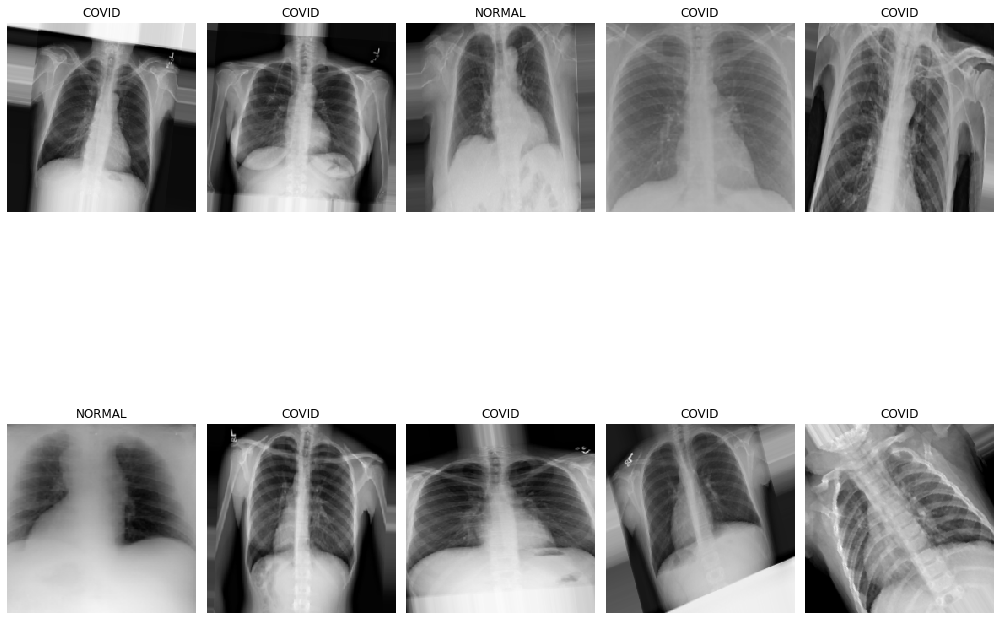

In [29]:
# Plot
plt.figure(figsize = (14, 14))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in dados_treino:
        imagem = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(imagem), cmap = 'gray', interpolation = 'nearest')
        break
plt.tight_layout()
plt.show()

### Modelagem - Transfer Learning

In [131]:
# Importa o modelo base
modelo_base = InceptionResNetV2(include_top = False, 
                                weights = 'imagenet',
                                input_shape = (224,224,3),
                                classifier_activation = 'sigmoid')

In [132]:
# Congela as camadas já treinadas
for layer in modelo_base.layers:           
    layer.trainable = False

In [133]:
# Adicionamos as camadas finais
x = Flatten()(modelo_base.output)
prediction = Dense(units = 1 , activation = 'sigmoid')(x)

In [134]:
# Cria o novo modelo
modelo_final = Model(modelo_base.input, prediction)

In [135]:
# Compila o modelo
modelo_final.compile(optimizer = Adam(0.0001),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

In [136]:
# Callback EarlyStopping
#callback_early = EarlyStopping(monitor = 'val_accuracy', 
                               #mode = 'min', 
                               #patience = 10)

In [137]:
# Callback ReduceLROnPlateau
callback_learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                     patience = 5, 
                                                     verbose = 1,
                                                     factor = 0.3, 
                                                     min_lr = 0.00001)

In [138]:
# Lista de callbacks
lista_callbacks = [callback_learning_rate_reduction]

In [139]:
# Computa o peso por classe
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(dados_treino.classes), y = dados_treino.classes)
peso_classe = dict(zip(np.unique(dados_treino.classes), weights))
print(peso_classe)

{0: 1.9092637400622192, 1: 0.6773975962717684}


In [140]:
# Treinamento do modelo
history = modelo_final.fit(dados_treino, 
                    steps_per_epoch = passos_treino, 
                    validation_data = dados_valid,
                    validation_steps = passos_val,
                    epochs = 25, 
                    verbose = 1,
                    class_weight = peso_classe,    
                    callbacks = lista_callbacks)

Epoch 1/25
173/173 [==============================] - 107s 616ms/step - loss: 0.4583 - accuracy: 0.7960 - val_loss: 0.2666 - val_accuracy: 0.9061
Epoch 2/25
173/173 [==============================] - 104s 600ms/step - loss: 0.3352 - accuracy: 0.8583 - val_loss: 0.2673 - val_accuracy: 0.8945
Epoch 3/25
173/173 [==============================] - 104s 599ms/step - loss: 0.3090 - accuracy: 0.8691 - val_loss: 0.2300 - val_accuracy: 0.9111
Epoch 4/25
173/173 [==============================] - 105s 605ms/step - loss: 0.3104 - accuracy: 0.8734 - val_loss: 0.2238 - val_accuracy: 0.9140
Epoch 5/25
173/173 [==============================] - 104s 603ms/step - loss: 0.2922 - accuracy: 0.8813 - val_loss: 0.2406 - val_accuracy: 0.9082
Epoch 6/25
173/173 [==============================] - 104s 600ms/step - loss: 0.2698 - accuracy: 0.8921 - val_loss: 0.2656 - val_accuracy: 0.8974
Epoch 7/25
173/173 [==============================] - 104s 598ms/step - loss: 0.2591 - accuracy: 0.8970 - val_loss: 0.2040 -

### Avaliação do Modelo

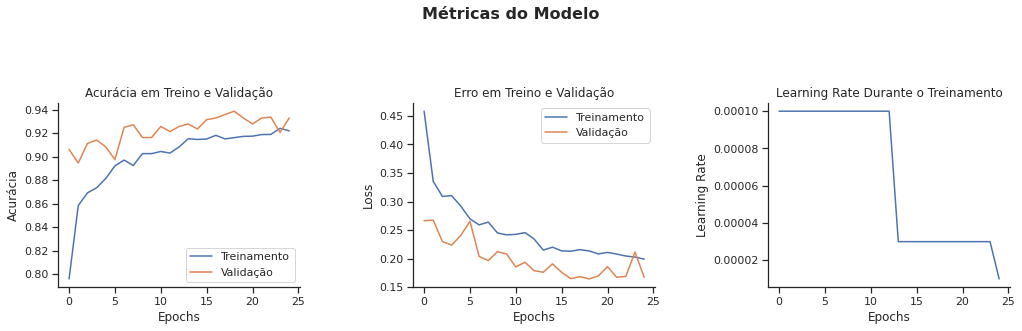

In [141]:
# Plot das métricas em treino e validação

# Área de plotagem
fig, axarr = plt.subplots(1, 3, figsize = (15,5), sharex = True)
sns.set(style = "ticks", font_scale = 1)
sns.despine(top = True, right = True, left = False, bottom = False)

# Histórico de treinamento do modelo
historyDF = pd.DataFrame.from_dict(history.history)

# Acurácia
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax = axarr[0], label = "Treinamento")
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax = axarr[0], label = "Validação")
ax.set_ylabel('Acurácia')

# Erro
ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax = axarr[1], label = "Treinamento")
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax = axarr[1], label = "Validação")
ax.set_ylabel('Loss')

# Learning Rate
ax = sns.lineplot(x = historyDF.index, y = history.history['lr'], ax = axarr[2])
ax.set_ylabel('Learning Rate')    

# Labels
axarr[0].set_title("Acurácia em Treino e Validação")
axarr[1].set_title("Erro em Treino e Validação")
axarr[2].set_title("Learning Rate Durante o Treinamento")

# Epochs
for ax in axarr:
    ax.set_xlabel('Epochs')

# Título
plt.suptitle('Métricas do Modelo', fontsize = 16, weight = 'bold')
fig.tight_layout(pad = 3.0)      
plt.show()

In [142]:
# Avaliação do modelo
acc_teste = modelo_final.evaluate(dados_teste)
print('Acurácia em Teste :', acc_teste[1]*100, '%')

1377/1377 [==============================] - 33s 24ms/step - loss: 0.1806 - accuracy: 0.9259
Acurácia em Teste : 92.59259104728699 %


In [143]:
# Previsões
preds = modelo_final.predict(dados_teste, verbose = 1)

1377/1377 [==============================] - 31s 23ms/step


In [144]:
# Cut-off
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

### Confusion Matrix

In [145]:
# Cria a matriz
matriz = pd.DataFrame(data = confusion_matrix(dados_teste.classes, predictions, labels = [0, 1]),
                      index = ["Normal Real", "COVID Real"],
                      columns = [" Normal Previsto", "COVID Previsto"])

<AxesSubplot:>

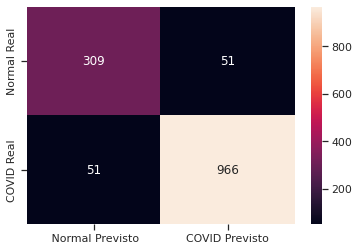

In [146]:
# Cria a matriz
sns.heatmap(matriz, annot = True, fmt = "d")

In [147]:
# Relatório de classificação
print(classification_report(y_true = dados_teste.classes,
                            y_pred = predictions,
                            target_names = ['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.86      0.86      0.86       360
       COVID       0.95      0.95      0.95      1017

    accuracy                           0.93      1377
   macro avg       0.90      0.90      0.90      1377
weighted avg       0.93      0.93      0.93      1377



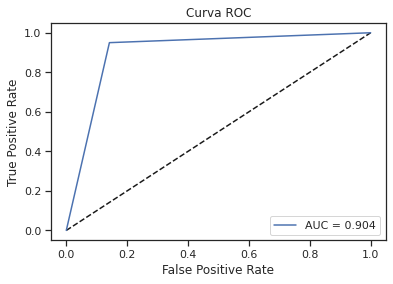

In [148]:
# Métricas do Modelo
fpr_keras, tpr_keras, thresholds_keras = roc_curve(dados_teste.classes, predictions)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label = 'AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc = 'best')
plt.show()

In [149]:
# Prepara x e y de teste
dados_teste.reset()
x = np.concatenate([dados_teste.next()[0] for i in range(dados_teste.__len__())])
y = np.concatenate([dados_teste.next()[1] for i in range(dados_teste.__len__())])
print(x.shape)
print(y.shape)

(1377, 224, 224, 3)
(1377,)


In [150]:
# Classes reais
y_true = dados_teste.classes

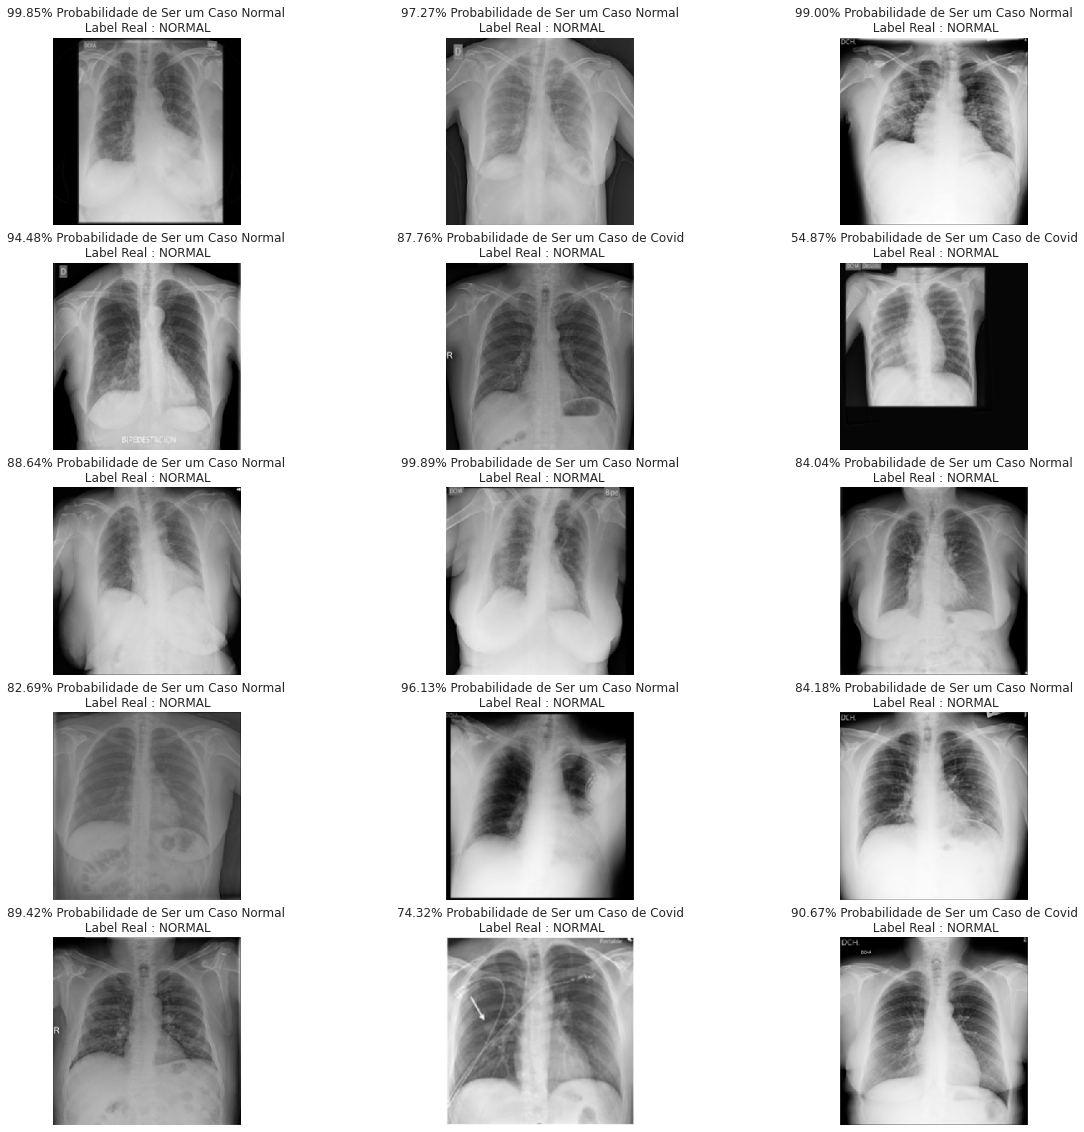

In [151]:
# Print de algumas imagens e previsões do modelo
dic = {0:'NORMAL', 1:'COVID'}
plt.figure(figsize = (20,20))
for i in range(0+224, 15+224):
    plt.subplot(5,3, (i-224)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} Probabilidade de Ser um Caso de Covid'.format(preds[i][0]))
    else: 
        out = ('{:.2%} Probabilidade de Ser um Caso Normal'.format(1 - preds[i][0]))
      
    plt.title(out + "\n Label Real : " + dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
plt.show()

### Previsão com o Modelo Treinado

In [152]:
# Carregando uma imagem
img1 = '/media/datasets/IAMED/Cap12/COVID-19_Radiography_Dataset/COVID/COVID-116.png'
img = image.load_img(img1, target_size = (224, 224))

In [153]:
# Pré-processamento da imagem
img_final = image.img_to_array(img)
img_final = img_final / 255
img_final = np.expand_dims(img_final, axis = 0)

In [154]:
# Previsões
previsao = modelo_final.predict(img_final)

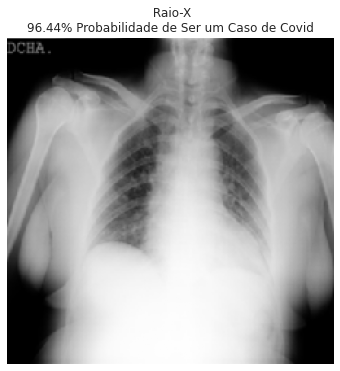

In [155]:
# Print
plt.figure(figsize = (6,6))
plt.axis('off')

if previsao >= 0.5: 
    saida = ('{:.2%} Probabilidade de Ser um Caso Normal'.format(previsao[0][0]))
else: 
    saida = ('{:.2%} Probabilidade de Ser um Caso de Covid'.format(1 - previsao[0][0]))
    
plt.title(" Raio-X\n" + saida)  
plt.imshow(np.squeeze(img_final))
plt.show()